In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import utils as u

In [2]:
EQ_CENTS = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
JI_CENTS = np.array([0, 90, 112, 182, 204, 294, 316, 386, 408, 498, 520, 590, 612, 702, 792, 814, 884, 906, 996, 1018, 1088, 1110, 1200])
notes_dict = {
"Sa": 0,
"Ri": 100,
"Ga": 300,
"Ma": 500,
"Pa": 700,
"Dha": 800,
"Ni": 1000,
"Sa": 1200,
"Ri": 1300,
"Ga": 1500,
}
sr = 16000

In [77]:
# Load processed pitch data
pitchfile = "thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-vocal-alaapana-processed.pitch"
times, f0 = np.loadtxt(pitchfile).T
length_s = times[-1]

# Track info
raga, piece, instrument, section = u.process_filename(pitchfile)
print("Raga:", raga)
print("Piece:", piece)
print("Instrument:", instrument)
print("Section:", section)

# Load the tonics
tonic_violin = np.loadtxt("thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-violin-main.tonic")
tonic_vocal = np.loadtxt("thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.ctonic.txt")
print("Violin tonic:", tonic_violin, "Hz, Vocal tonic:", tonic_vocal, "Hz")

# Set the tonic based on the instrument
if instrument == "vocal":
    tonic = tonic_vocal
    print("Using vocal tonic")
else:
    tonic = tonic_violin
    print("Using violin tonic")

Raga: thodi
Piece: Karuna Nidhi Illalo
Instrument: vocal
Section: alaapana
Violin tonic: 135.63082885742188 Hz, Vocal tonic: 135.425885 Hz
Using vocal tonic


In [78]:
# Cents calculation
cents = u.hz_to_cents(f0, tonic)
cents = u.wrap_to_octave(cents)

#### Histogram

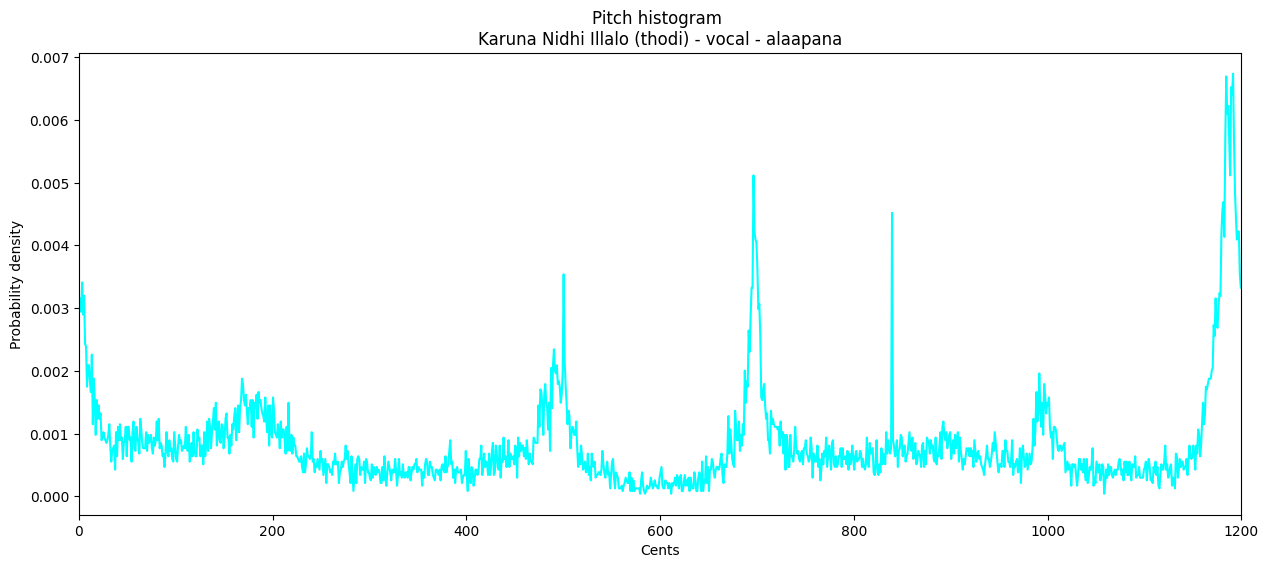

In [79]:
# Plot histogram
bins = np.linspace(0, 1200, 1201)
hist, bin_edges = np.histogram(cents, bins = bins)
hist = hist/np.sum(hist)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2    

plt.figure(figsize=(15, 6))
plt.plot(bin_centers, hist, color = "cyan")
plt.xlabel("Cents")
plt.ylabel("Probability density")
plt.xlim(0, 1200)
plt.title("Pitch histogram \n" + piece + " (" + raga + ") - " + instrument + " - " + section)
plt.show()       


#### Save raw pitch histograms

In [80]:
hist_file = pitchfile.replace("processed.pitch", "histogram.txt")
np.savetxt(hist_file, np.vstack((bin_centers, hist)).T, fmt = "%.6f")

#### KDE

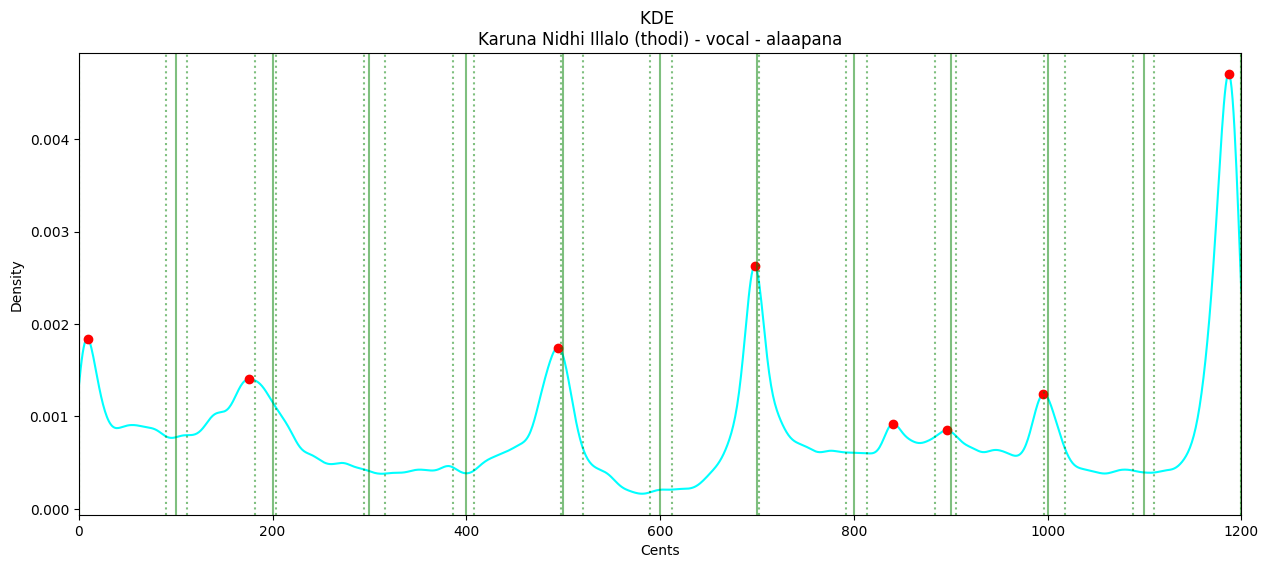

In [81]:
# KDE calculation
kde = u.gaussian_kde(cents[~np.isnan(cents)], bw_method = 0.02)
bins = np.linspace(0, 1200, 1200)
kde_vals = kde(bins)

# Find peaks in KDE
peaks,_ = u.find_peaks(kde_vals, distance = 50, height = 0.0008)

# Plot KDE and peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE \n" + piece + " (" + raga + ") - " + instrument + " - " + section)
plt.show()


#### Peak Fitting

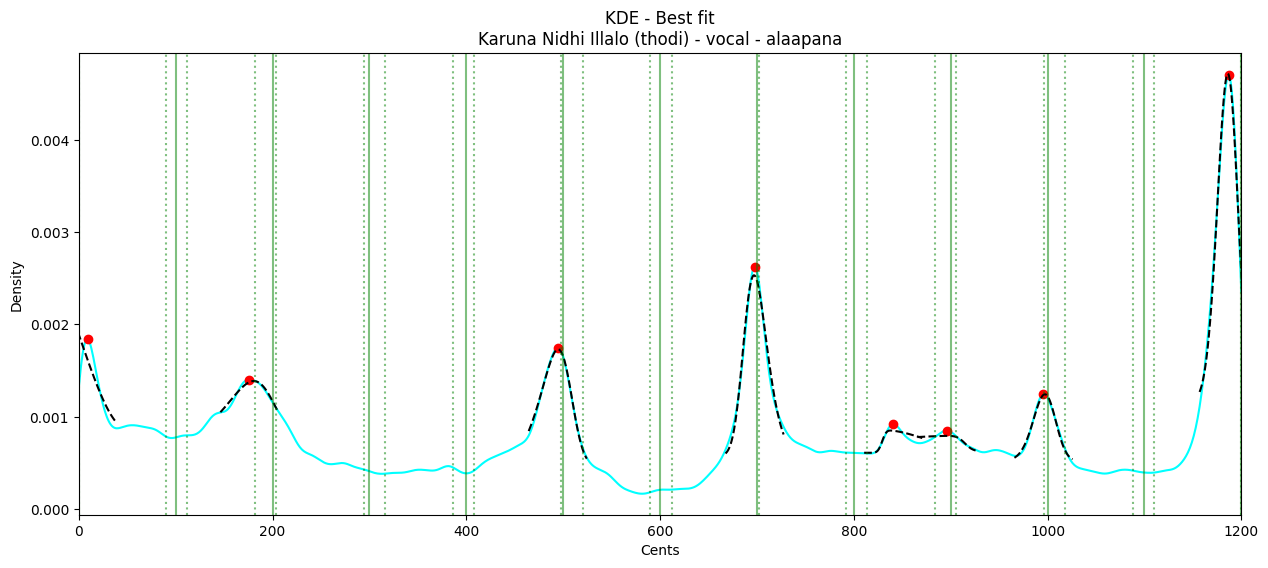

In [82]:
# Find peak parameters
peak_dict = u.fit_histogram(peaks, kde_vals, bins)

# Plot KDE and fitted peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for peak, params in peak_dict.items():
    start = peak - 30
    end = peak + 30
    x_vals = np.linspace(start, end, 100)
    y_vals = u.gaussian(x_vals, *params)
    plt.plot(x_vals, y_vals, linestyle = '--', color = 'k')

for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE - Best fit\n" + piece + " (" + raga + ") - " + instrument + " - " + section)

# Save figure
figfile = pitchfile.replace("processed.pitch", "kde.png")
plt.savefig(figfile)

plt.show()

In [83]:
# For each peak, find the closest JI and EQ pitch
ji_pitch = []
eq_pitch = []
ji_diff = []
eq_diff = []
for peak in peaks:
    peak_pos = int(bins[peak])
    ji = JI_CENTS[np.argmin(np.abs(JI_CENTS - peak_pos))]
    eq = EQ_CENTS[np.argmin(np.abs(EQ_CENTS - peak_pos))]
    ji_pitch.append(ji)
    eq_pitch.append(eq)
    ji_diff.append(np.abs(peak_pos - ji))
    eq_diff.append(np.abs(peak_pos - eq))

import pandas as pd
df = pd.DataFrame(list(zip(bins[peaks].astype(int), ji_pitch, ji_diff, eq_pitch, eq_diff)), columns = ["Peak", "JI", "JI_diff", "EQ", "EQ_diff"])
display(df)

,Peak,JI,JI_diff,EQ,EQ_diff
0,9,0,9,0,9
1,176,182,6,200,24
2,494,498,4,500,6
3,697,702,5,700,3
4,840,814,26,800,40
5,895,884,11,900,5
6,995,996,1,1000,5
7,1186,1200,14,1200,14


In [84]:
# Store the peak parameters in a dataframe
mean_pos = [int(key) for key in peak_dict.keys()]
amplitudes = [value[0] for value in peak_dict.values()]
stds = [value[2] for value in peak_dict.values()]
offsets = [value[3] for value in peak_dict.values()]
skewness = [value[4] for value in peak_dict.values()]

# Normalize the amplitudes and offsets as they are in arbitrary units
amplitudes = amplitudes/np.sum(amplitudes)
offsets = offsets/np.sum(offsets)

# Display the peak parameters
pd.options.display.float_format = '{:.2f}'.format
df = pd.DataFrame(list(zip(mean_pos, amplitudes, stds, offsets, skewness)), columns = ["Mean (cents)", "Amplitude (normalized)", "Standard Deviation (cents)", "Offset (normalized)", "Skewness"])
display(df)

,Mean (cents),Amplitude (normalized),Standard Deviation (cents),Offset (normalized),Skewness
0,9,-0.62,-48.46,0.41,-0.01
1,176,0.11,39.07,0.09,-2.31
2,494,0.21,25.42,0.06,-2.38
3,697,0.35,18.30,0.07,1.91
4,840,0.03,44.26,0.08,12.88
5,895,0.02,111.54,0.08,-16.97
6,995,0.14,15.11,0.07,-1.24
7,1186,0.76,12.87,0.14,-0.99


In [85]:
# Save df to a file
csvfile = pitchfile.replace("processed.pitch", "peaks.csv")
df.to_csv(csvfile, index = False)